=== Inputs ===
Parachute Surface Area: 3.14 ft^2
Drone Weight: 0.95 lbs
Nominal Diameter: 1.00 ft
Sea-Level Descent Rate (no inflation time): 15.93 ft/s

Initial Altitude: 36.00 ft
Free Fall Time: 0.00 s
Parachute Fill Time: 0.00 s

=== Outputs ===
Max Speed: 14.67 ft/s
Max Absolute Acceleration: 32.20 ft/s² (1.00 Gs)
Final Speed At Impact: 14.67 ft/s
Impact Energy: 4.30 J


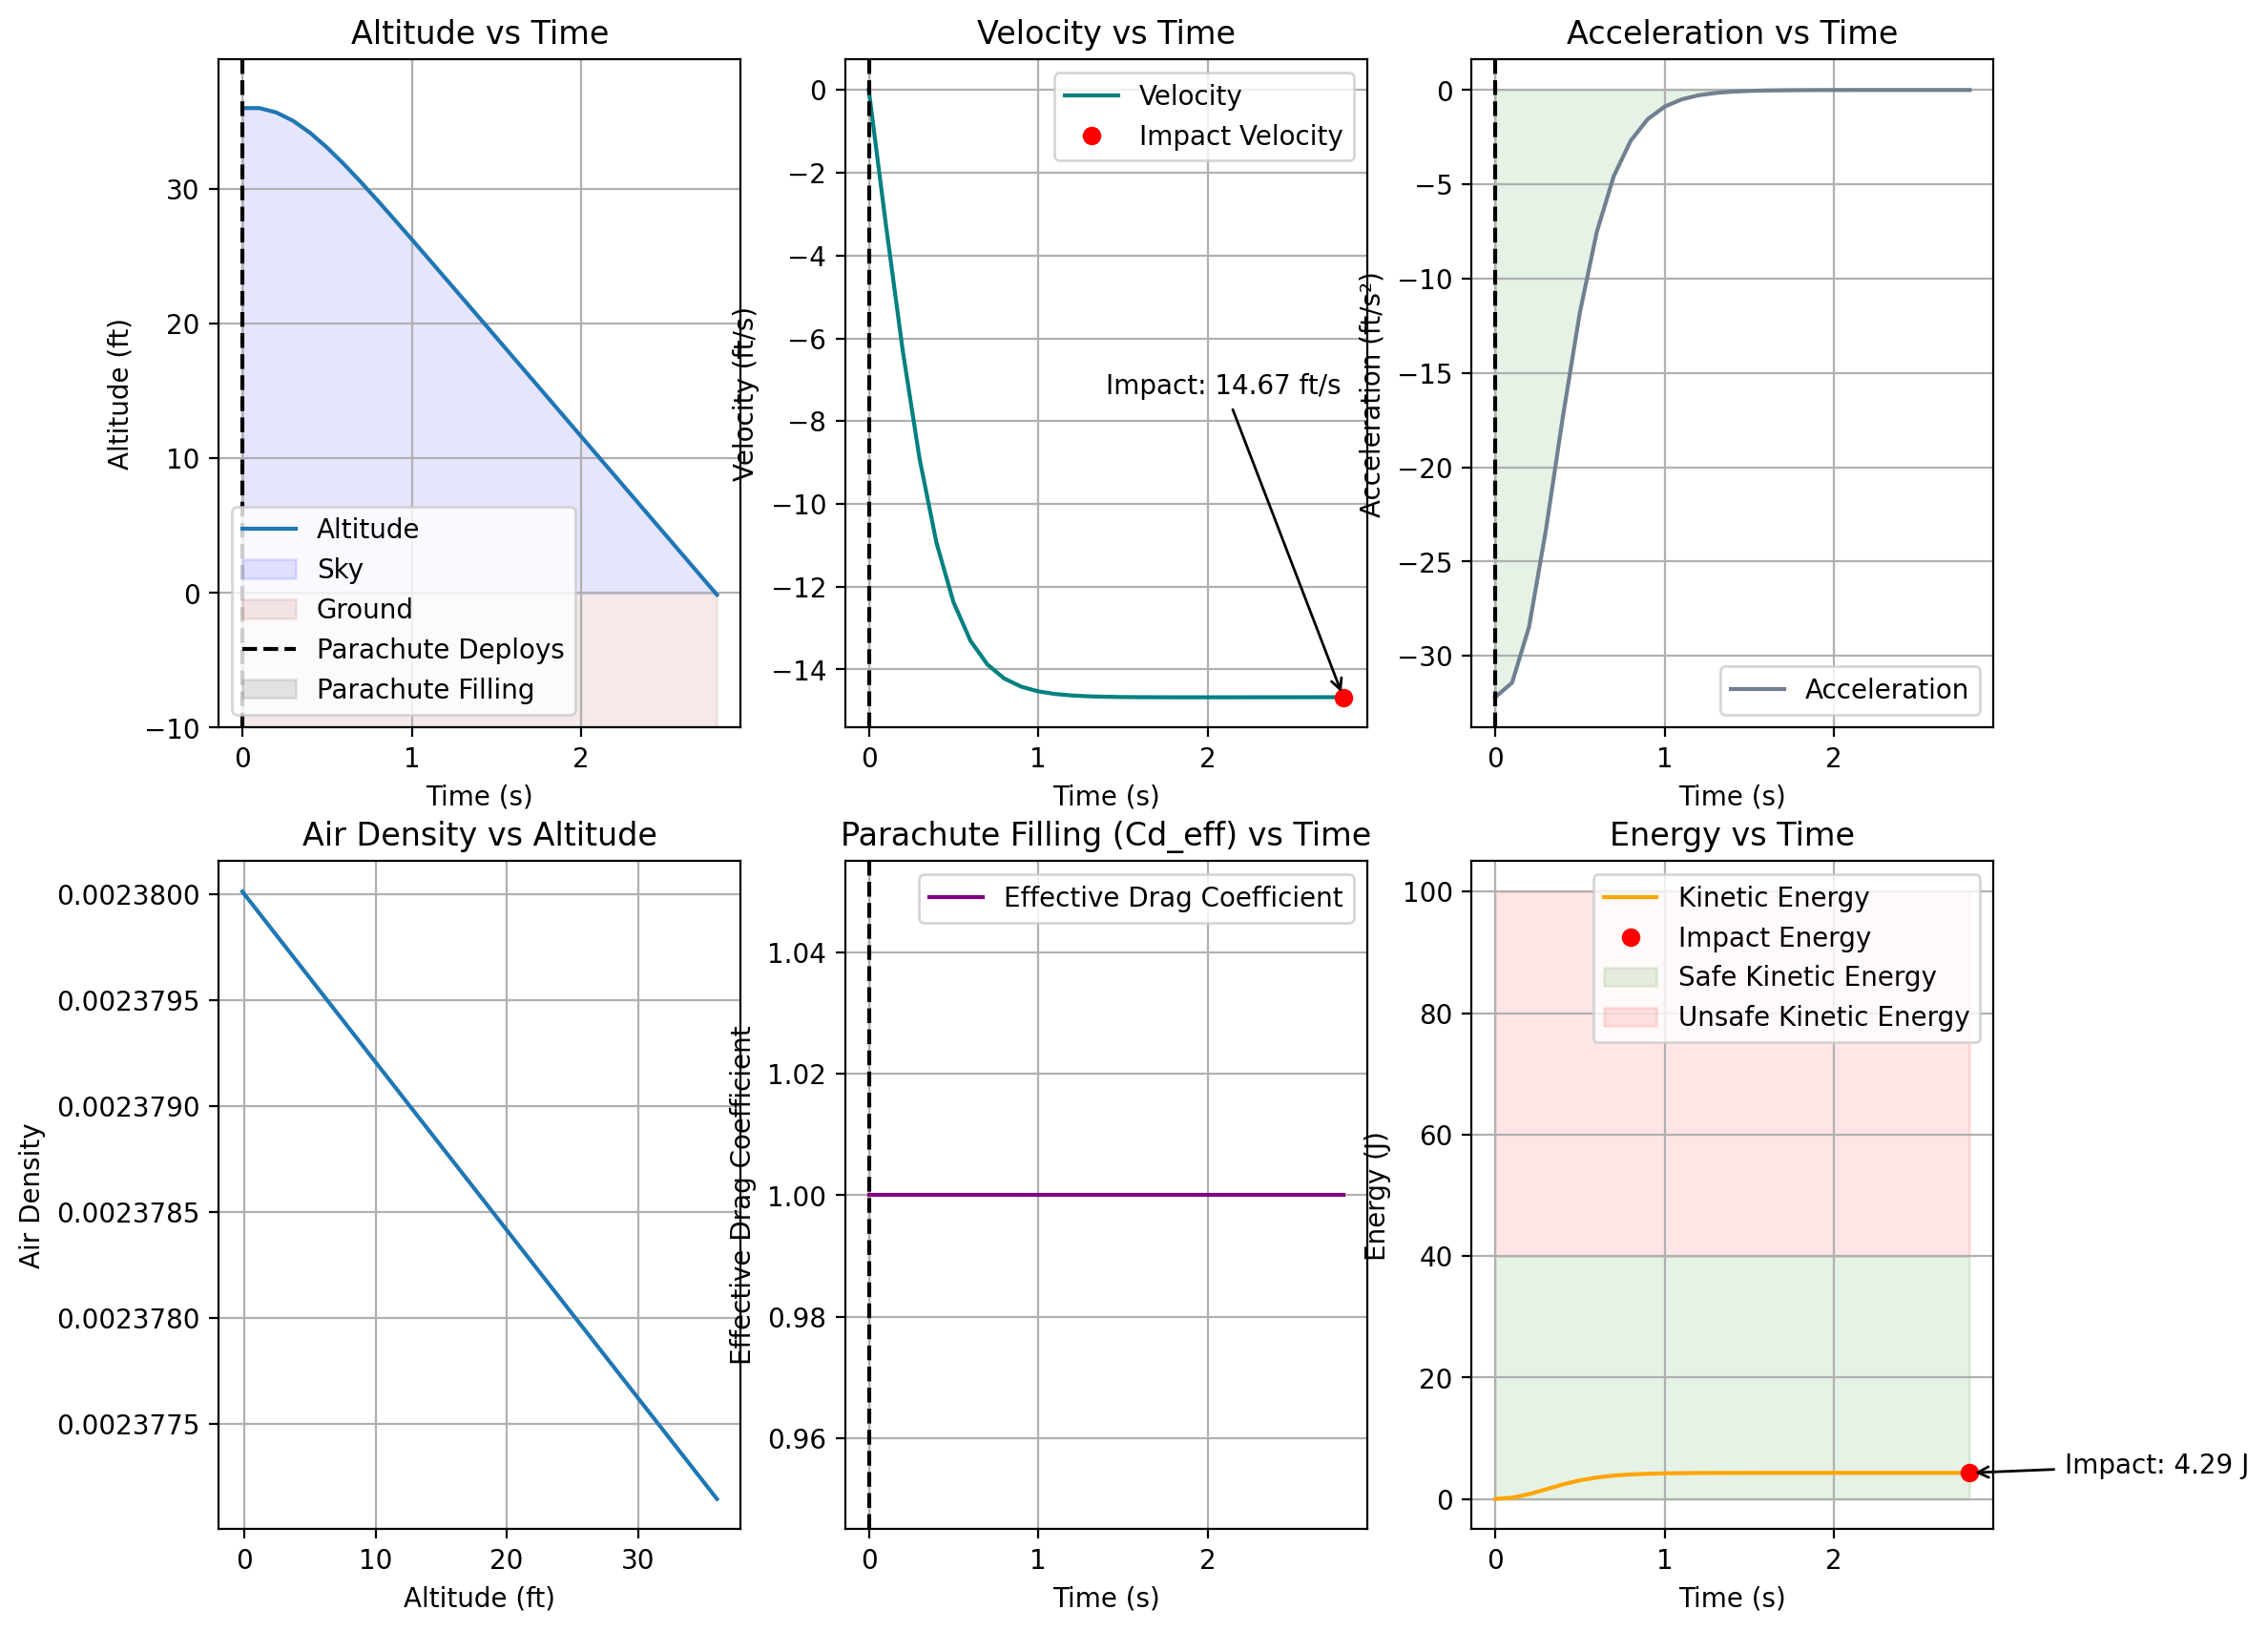

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Callable
# from scipy.integrate import solve_ivp  # Removed since we now use Euler

@dataclass
class ParachuteParameters:
    """Class to hold parachute design parameters"""
    So: float  # Total projected canopy area (ft²)
    Wt: float  # Total weight (lbs)
    Cdo: float  # Drag coefficient
    n: float   # Dimensionless fill constant
    payload_surface_area: float = 0.0  # Payload surface area (ft²)
    payload_drag_coefficient: float = 0.0  # Payload drag coefficient


class ParachuteCalculator:
    """Class to perform parachute design calculations"""
    
    def __init__(self, params: ParachuteParameters):
        self.params = params
        # Standard sea level air density (slugs/ft³ or kg/m³)
        self.rho_sea_level = 0.00238  # slugs/ft³ (1.225 kg/m³) - at sea level and at 15°C
        self.g = 32.2  # ft/s² (9.81 m/s²)
    
    def compute_drag_coefficient(self, t: float, free_fall_time: float, fill_time: float) -> float:
        """
        Compute the effective drag coefficient based on time.
        """
        if t < free_fall_time:
            return 0.0  # No drag before parachute starts opening
        elif free_fall_time <= t < free_fall_time + fill_time:
            # Nonlinear increase in drag coefficient during inflation
            inflation_progress = (t - free_fall_time) / fill_time
            return self.params.Cdo * (1 - np.exp(-inflation_progress * 5))  # Exponential growth
        else:
            return self.params.Cdo  # Fully deployed after fill time
    
    def calculate_nominal_diameter(self) -> float:
        return np.sqrt((self.params.So / np.pi))
    
    def calculate_descent_rate_sea_level(self) -> float:
        return np.sqrt((2 * self.params.Wt) / 
                       (self.params.So * self.params.Cdo * self.rho_sea_level))
    
    def calculate_descent_rate_altitude(self, rho_altitude: float) -> float:
        vco = self.calculate_descent_rate_sea_level()
        return vco * np.sqrt(self.rho_sea_level / rho_altitude)
    
    def calculate_filling_distance(self, Dp: float) -> float:
        return self.params.n * Dp
    
    def simulate_descent(self, 
                         initial_altitude: float, 
                         free_fall_time: float = 0, 
                         fill_time: float = 1.0,
                         dt: float = 0.1, 
                         rho_altitude_func: Callable[[float], float] = None
                         ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Simulate complete descent using a simple Forward Euler integrator.
        
        Returns:
            time_points (np.ndarray): Time steps
            altitudes   (np.ndarray): Altitude at each time step
            velocities  (np.ndarray): Velocity at each time step
            accelerations (np.ndarray): Acceleration at each time step (approx. from velocity differences)
            rho_values  (np.ndarray): Air density at each altitude
        """
        if rho_altitude_func is None:
            # Default: exponential decay with altitude
            rho_altitude_func = lambda h: self.rho_sea_level * np.exp(-h / 30000)
        
        # Setup time array
        t_max = 1000.0  # Arbitrary maximum simulation time
        time_points = np.arange(0, t_max, dt)
        
        # Arrays to store altitude, velocity, etc.
        altitudes = np.zeros_like(time_points)
        velocities = np.zeros_like(time_points)
        altitudes[0] = initial_altitude  # start altitude
        velocities[0] = 0.0             # start velocity (assume 0 ft/s)
        
        # For convenience, store air density in each time step
        rho_values = np.zeros_like(time_points)
        
        # Convert weight (lbf) to mass (slugs)
        mass = self.params.Wt / self.g
        
        # Euler integrator
        for i in range(len(time_points) - 1):
            
            t = time_points[i]
            h = altitudes[i]
            v = velocities[i]
            
            # If we've hit or gone below ground, stop
            if h <= 0:
                # Truncate arrays to current index
                altitudes[i:] = altitudes[i]
                velocities[i:] = velocities[i]
                break
            
            # Compute air density at current altitude
            rho = rho_altitude_func(h)
            rho_values[i] = rho
            
            # Gravitational force
            Fg = self.params.Wt  # lbf
            
            # Effective drag coefficient
            Cdo_eff = self.compute_drag_coefficient(t, free_fall_time, fill_time)
            
            # Drag force from parachute
            Fd_parachute = 0.5 * rho * (v**2) * Cdo_eff * self.params.So
            
            # Drag force from payload
            Fd_payload = 0.5 * rho * (v**2) \
                         * self.params.payload_drag_coefficient \
                         * self.params.payload_surface_area

            # Total drag
            Fd_total = Fd_parachute + Fd_payload
            
            # Net force (Downward = positive, so Fg - Fd_total)
            F_net = Fg - Fd_total
            
            # Acceleration (ft/s^2)
            a = F_net / mass
            
            # Forward Euler update
            # altitudes: h_{k+1} = h_k + dt * v_k
            # velocities: v_{k+1} = v_k + dt * (-a)
            # (We use "-a" to keep velocity negative if v is downwards.)
            altitudes[i+1] = h + dt * v
            velocities[i+1] = v + dt * (-a)
        
        # Truncate arrays if simulation ended early
        ground_index = np.where(altitudes <= 0)[0]
        if len(ground_index) > 0:
            stop_index = ground_index[0]
            time_points = time_points[:stop_index + 1]
            altitudes   = altitudes[:stop_index + 1]
            velocities  = velocities[:stop_index + 1]
            rho_values  = rho_values[:stop_index + 1]
        
        # Compute approximate acceleration from velocity using numerical differentiation
        accelerations = np.gradient(velocities, time_points)
        rho_values[-1] = rho_altitude_func(altitudes[-1])  # fill last element in case we ended normally
        
        return time_points, altitudes, velocities, accelerations, rho_values
    
    def plot_descent_simulation(self, 
                                Wt: float,
                                initial_altitude: float, 
                                free_fall_time: float = 0, 
                                dt: float = 0.1,
                                fill_time: float = 1.0,
                                rho_altitude_func: Callable[[float], float] = None) -> None:
        """
        Plots the descent simulation results:
          - altitude vs time
          - velocity vs time
          - acceleration vs time
          - air density vs altitude
          - effective drag coefficient vs time
          - kinetic energy vs time
        """
        # Run the Euler-based simulation
        times, altitudes, velocities, accelerations, rho_values = self.simulate_descent(
            initial_altitude, free_fall_time, fill_time, dt, rho_altitude_func
        )
        
        print(f"Initial Altitude: {initial_altitude:.2f} ft")
        print(f"Free Fall Time: {free_fall_time:.2f} s")
        print(f"Parachute Fill Time: {fill_time:.2f} s")
        print("\n=== Outputs ===")
        print(f"Max Speed: {max(abs(velocities)):.2f} ft/s")
        max_acceleration = max(abs(accelerations))  # Maximum absolute acceleration in ft/s²
        max_acceleration_gs = max_acceleration / self.g  # Convert ft/s² to Gs
        print(f"Max Absolute Acceleration: {max_acceleration:.2f} ft/s² ({max_acceleration_gs:.2f} Gs)")
        print(f"Final Speed At Impact: {abs(velocities[-1]):.2f} ft/s")

        # Convert final velocity to SI units for impact energy
        FT_TO_M = 0.3048
        LB_TO_KG = 0.453592
        vco_mps = abs(velocities[-1]) * FT_TO_M
        mass_kg = Wt * LB_TO_KG
        impact_energy_joules = 0.5 * mass_kg * vco_mps**2
        print(f"Impact Energy: {impact_energy_joules:.2f} J")

        # Now create the plots
        fig, axs = plt.subplots(2, 3, figsize=(12, 10), dpi=200)
        ax1, ax2, ax3, ax4, ax5, ax6 = axs.flat

        # Altitude plot
        ax1.plot(times, altitudes, label='Altitude')
        ax1.fill_between(times, 0, np.maximum(0, altitudes), color='blue', alpha=0.1, label='Sky')
        ax1.fill_between(times, -10, 0, color='brown', alpha=0.1, label='Ground')
        ax1.axvline(free_fall_time, color='black', linestyle='--', label='Parachute Deploys')
        parachute_fill_end = free_fall_time + fill_time
        if parachute_fill_end <= times[-1]:
            ax1.axvspan(free_fall_time, parachute_fill_end, color='gray', alpha=0.2, label='Parachute Filling')
        ax1.set_ylim(-10, max(altitudes)*1.1 if len(altitudes) else 0)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Altitude (ft)')
        ax1.set_title('Altitude vs Time')
        ax1.legend()
        ax1.grid(True)

        # Velocity plot
        ax2.plot(times, velocities, label='Velocity', color='teal')
        ax2.axvline(free_fall_time, color='black', linestyle='--')
        if parachute_fill_end <= times[-1]:
            ax2.axvspan(free_fall_time, parachute_fill_end, color='gray', alpha=0.2)
        impact_time = times[-1]
        impact_velocity = velocities[-1]
        ax2.plot(impact_time, impact_velocity, 'ro', label="Impact Velocity")
        ax2.annotate(f"Impact: {abs(impact_velocity):.2f} ft/s",
                     xy=(impact_time, impact_velocity),
                     xytext=(impact_time * 0.5, impact_velocity * 0.5),
                     arrowprops=dict(facecolor='black', arrowstyle="->"),
                     fontsize=10)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Velocity (ft/s)')
        ax2.set_title('Velocity vs Time')
        ax2.legend()
        ax2.grid(True)

        # Acceleration plot
        ax3.plot(times, accelerations, label='Acceleration', color="slategray")
        ax3.axvline(free_fall_time, color='black', linestyle='--')
        if parachute_fill_end <= times[-1]:
            ax3.axvspan(free_fall_time, parachute_fill_end, color='gray', alpha=0.2)
        ax3.fill_between(times, accelerations, 0, where=(accelerations < 0), color='green', alpha=0.1)
        ax3.fill_between(times, accelerations, 0, where=(accelerations > 0), color='red', alpha=0.1)
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Acceleration (ft/s²)')
        ax3.set_title('Acceleration vs Time')
        ax3.legend()
        ax3.grid(True)

        # Air density vs altitude
        ax4.plot(altitudes, rho_values, label='Air Density')
        ax4.set_xlabel('Altitude (ft)')
        ax4.set_ylabel('Air Density')
        ax4.set_title('Air Density vs Altitude')
        ax4.grid(True)

        # Effective drag coefficient over time
        Cd_eff = [self.compute_drag_coefficient(t, free_fall_time, fill_time) for t in times]
        ax5.plot(times, Cd_eff, label='Effective Drag Coefficient', color='purple')
        ax5.axvline(free_fall_time, color='black', linestyle='--')
        if parachute_fill_end <= times[-1]:
            ax5.axvspan(free_fall_time, parachute_fill_end, color='gray', alpha=0.2)
        ax5.set_xlabel('Time (s)')
        ax5.set_ylabel('Effective Drag Coefficient')
        ax5.set_title('Parachute Filling (Cd_eff) vs Time')
        ax5.legend()
        ax5.grid(True)

        # Kinetic Energy vs Time
        # Convert weight to mass in slugs again for consistency
        mass_slugs = Wt / self.g
        potential_energy = mass_slugs * self.g * np.array(altitudes)  # in ft-lb
        kinetic_energy = 0.5 * mass_slugs * np.array(velocities)**2   # in ft-lb
        total_energy = potential_energy + kinetic_energy

        # Convert ft-lb to Joules
        FT_LB_TO_JOULE = 1.3558179483
        kinetic_energy_joules = kinetic_energy * FT_LB_TO_JOULE

        ax6.plot(times, kinetic_energy_joules, label="Kinetic Energy", color="orange")
        ax6.plot(times[-1], kinetic_energy_joules[-1], 'ro', label="Impact Energy")
        ax6.annotate(f"Impact: {kinetic_energy_joules[-1]:.2f} J",
                     xy=(times[-1], kinetic_energy_joules[-1]),
                     xytext=(times[-1] * 1.2, kinetic_energy_joules[-1]),
                     arrowprops=dict(facecolor='black', arrowstyle="->"),
                     fontsize=10)
        # Safe/unsafe shading
        ax6.fill_between(times, 0, 40, color='green', alpha=0.1, label='Safe Kinetic Energy')
        ax6.fill_between(times, 40, 100, color='red', alpha=0.1, label='Unsafe Kinetic Energy')
        ax6.set_title("Energy vs Time")
        ax6.set_xlabel("Time (s)")
        ax6.set_ylabel("Energy (J)")
        ax6.legend()
        ax6.grid(True)

        plt.show()


# Example usage
def example_calculation():
    # Example parameters (using imperial units)
    params = ParachuteParameters(
        So=3.14,              # ft²
        Wt=0.948,             # lbs
        Cdo=1.0,              # typical for round parachute
        n=3.0,                # typical fill constant
        payload_surface_area=0.375,
        payload_drag_coefficient=1.5
    )
    
    calculator = ParachuteCalculator(params)

    # Print a few values
    Do = calculator.calculate_nominal_diameter()
    vco = calculator.calculate_descent_rate_sea_level()
    print("=== Inputs ===")
    print(f"Parachute Surface Area: {params.So:.2f} ft^2")
    print(f"Drone Weight: {params.Wt:.2f} lbs")
    print(f"Nominal Diameter: {Do:.2f} ft")
    print(f"Sea-Level Descent Rate (no inflation time): {vco:.2f} ft/s\n")
    
    # Run and plot the complete descent simulation with Euler method
    calculator.plot_descent_simulation(
        Wt=params.Wt, 
        initial_altitude=36,   # e.g. 36 ft
        free_fall_time=0, 
        dt=0.1, 
        fill_time=0
    )


if __name__ == "__main__":
    example_calculation()
